In [84]:
!conda install tabulate -y

Channels:
 - conda-forge
 - defaults
Platform: osx-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 23.9.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [85]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate


# COMM477 Pricing Asset using Monte Carlo Simulation 

# 1. Preparing Data

#### 1.1 Reading the Data

In [86]:
# Load underlying asset's historical price data
data = pd.read_excel('data/index_price.xlsx')
data.head()

,Date,Price
0,2019-10-31,100.00
1,2019-11-01,100.07
2,2019-11-04,99.83
3,2019-11-05,99.29
4,2019-11-06,100.12


#### 1.2 Turning Price into Float Data Type

In [87]:

# data['Price']= data['Price'].str.replace('$', '').astype(float) 

### 1.3 Converting Date to datetime Datatype

In [88]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')

In [89]:
data.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

### 1.4 Sorting data in order of date

In [90]:
data.sort_values('Date', inplace=True)

In [91]:
data.head()

,Date,Price
0,2019-10-31,100.00
1,2019-11-01,100.07
2,2019-11-04,99.83
3,2019-11-05,99.29
4,2019-11-06,100.12


# 2. Calculations for Simulation

### 2.1 Calculating Returns

In [92]:
# creating returns columns 
data["Returns"] = np.log(1+data['Price'].pct_change()).dropna()

# setting date as the index
data.set_index('Date', inplace=True)


In [93]:
data.tail()

,Price,Returns
Date,,
2024-04-02,119.41,-0.014632
2024-04-03,118.80,-0.005122
2024-04-04,118.47,-0.002782
2024-04-05,119.67,0.010078
2024-04-08,119.99,0.002670


### 2.2 Calculating Variables

In [94]:
mu, sig = data['Returns'].mean(), data['Returns'].std()
initial = data['Price'].iloc[-1]
risk_free_rate = 0.0359 # 10 year candian treasury bill rate
ending_prices = []
final_returns = [] 

# 3. Monte Carlo Simulation

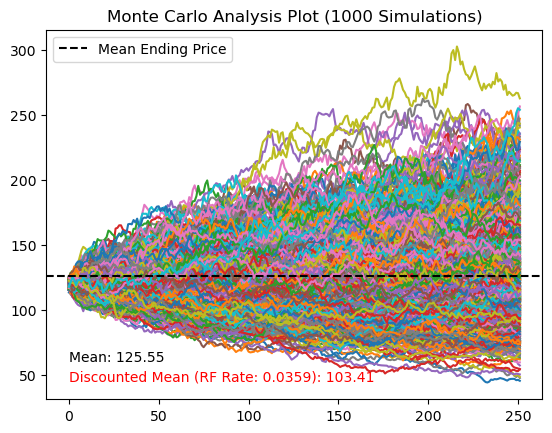

In [95]:
num_sims = 1000 # number of simulations

for i in range(num_sims):
    sim_rets = np.random.normal(mu, sig, 252)
    sim_prices = initial * (sim_rets + 1).cumprod()
    ending_prices.append(sim_prices[-1])
    
    # Calculate the underlying performance as a percentage
    performance = (sim_prices[-1] / initial - 1) * 100
    
    # applying the strucutre mentioned in the product overview 
    if performance > 152:
        final_return = initial * (1 + (performance - 152) / 100 + 1) # Principal + 100% of the performance above 152%
    elif 100 < performance <= 152:
        final_return = initial * (1 + 0.52) # Principal + 52%
    elif 80 < performance <= 100:
        final_return = initial 
    else: 
        final_return = initial * (performance / 100 + 1)  # if performance worse than 80, just receive underlying princi
    
    final_returns.append(final_return)
    
    plt.plot(sim_prices)

mean_value = np.mean(ending_prices)
plt.axhline(mean_value, color='black', linestyle='--', label='Mean Ending Price')
plt.text(x=0, y=60, s=f'Mean: {mean_value:.2f}', color='black')
plt.text(x=0, y=45, s=f'Discounted Mean (RF Rate: {risk_free_rate}): {mean_value/(1+risk_free_rate)**5.5:.2f}', color='red')

plt.title(f'Monte Carlo Analysis Plot ({num_sims} Simulations)')
plt.legend()
plt.show()



### 3.1 Using Median to Obtain the Price at Maturity 

In [96]:
estimated_price_at_maturity_median = np.median(ending_prices) 
print("Estimated Price at Maturity:", estimated_price_at_maturity_median)

Estimated Price at Maturity: 120.47992596553607


### 3.2 Using Mean to Obtain the Price at Maturity 

In [97]:
estimated_price_at_maturity_mean = np.mean(ending_prices)
print("Estimated Price at Maturity:", estimated_price_at_maturity_mean)

Estimated Price at Maturity: 125.54815490029165


# 4. Discounting Estimated Price ot Maturity

In [98]:
def discount(price, rf, time_to_maturity):
    discounted_price = price / (1+risk_free_rate)** 5.5
    return discounted_price

In [99]:
discounted_price_median = discount(price=estimated_price_at_maturity_median, rf=risk_free_rate, time_to_maturity=5.5)


discounted_price_median

99.23539668880879

In [100]:
discounted_price_mean = discount(price=estimated_price_at_maturity_mean, rf=risk_free_rate, time_to_maturity=5.5)

discounted_price_mean

103.4099320300244

# 5. Sensitivity Analysis / Stress Testing

In [101]:
mu = data['Returns'].mean()
sigma = data['Returns'].std()
initial = data['Price'].iloc[-1]
num_sims = 1000
num_days = 252
risk_free_rate = 0.0359  # 10 month us canadian treasury bill

# range for sensitivity analysis
mu_values = np.linspace(mu * 0.8, mu * 1.2, 5)
sigma_values = np.linspace(sigma * 0.7, sigma * 1.3, 5)

# storing results
results_list = []

for mu_val in mu_values:
    for sigma_val in sigma_values:
        ending_prices = []
        final_returns = []

        for i in range(num_sims):
            sim_rets = np.random.normal(mu_val, sigma_val, num_days)
            sim_prices = initial * (sim_rets + 1).cumprod()
            ending_prices.append(sim_prices[-1])
            performance = (sim_prices[-1] / initial - 1) * 100

            # apply security payoff structure 
            if performance > 152:
                final_return = initial * (1 + (performance - 152) / 100 + 1)
            elif 100 < performance <= 152:
                final_return = initial * (1 + 0.52)
            elif 80 < performance <= 100:
                final_return = initial
            else:
                final_return = initial * (performance / 100 + 1)
                
            final_returns.append(final_return)


        avg_ending_price = np.mean(ending_prices)
        
        results_list.append({
            'Diff (Mu)': mu_val - mu,
            'Diff (Sigma)': sigma_val - sigma,
            'Adj Mu': mu_val,
            'Adj Sigma': sigma_val,
            'Mean Ending Price': avg_ending_price,
            'Discounted Price':  discount(price=avg_ending_price, rf=risk_free_rate, time_to_maturity=5.5)
        })



results = pd.DataFrame(results_list)
results


,Diff (Mu),Diff (Sigma),Adj Mu,Adj Sigma,Mean Ending Price,Discounted Price
0,-0.000033,-0.005282,0.000131,0.012326,123.917033,102.066430
1,-0.000033,-0.002641,0.000131,0.014967,124.191840,102.292780
2,-0.000033,0.000000,0.000131,0.017608,124.187617,102.289301
3,-0.000033,0.002641,0.000131,0.020249,122.128410,100.593199
4,-0.000033,0.005282,0.000131,0.022890,125.714876,103.547255
5,-0.000016,-0.005282,0.000148,0.012326,124.651054,102.671019
6,-0.000016,-0.002641,0.000148,0.014967,125.531350,103.396091
7,-0.000016,0.000000,0.000148,0.017608,123.598493,101.804059
8,-0.000016,0.002641,0.000148,0.020249,122.910107,101.237058
9,-0.000016,0.005282,0.000148,0.022890,125.715110,103.547448


In [102]:
# styling options: 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdP

# Sensitivity Table 

*Note: Red Values correspond to the lower values in the column whilst blue values correspond to higher values in the column*

![Sensitivity Table](formatted_sensitivity_table.png)


In [109]:
styled_results = results.style.background_gradient(cmap='RdBu')  
print(f'Original Mu: {mu} \nOriginal Sigma: {sigma}')
styled_results.to_html
# note: colour mapping doesn't render on github
styled_results

Original Mu: 0.00016417857656595184 
Original Sigma: 0.017607860814631792


,Diff (Mu),Diff (Sigma),Adj Mu,Adj Sigma,Mean Ending Price,Discounted Price
0,-0.000033,-0.005282,0.000131,0.012326,123.917033,102.066430
1,-0.000033,-0.002641,0.000131,0.014967,124.191840,102.292780
2,-0.000033,0.000000,0.000131,0.017608,124.187617,102.289301
3,-0.000033,0.002641,0.000131,0.020249,122.128410,100.593199
4,-0.000033,0.005282,0.000131,0.022890,125.714876,103.547255
5,-0.000016,-0.005282,0.000148,0.012326,124.651054,102.671019
6,-0.000016,-0.002641,0.000148,0.014967,125.531350,103.396091
7,-0.000016,0.000000,0.000148,0.017608,123.598493,101.804059
8,-0.000016,0.002641,0.000148,0.020249,122.910107,101.237058
9,-0.000016,0.005282,0.000148,0.022890,125.715110,103.547448


### References

Listed in references.txt
